In [1]:
import torch
import os
import torch.nn.init as init
from torchvision import datasets, transforms
from torch import optim, nn
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import logging
import math

In [2]:
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_settings = {
    "Baseline_0": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": None, "factor": 1},
    "Baseline_1": {"epochs": 4, "lr": 0.001, "l2": 1e-4, "loss_type": None, "factor": 1},
    "Baseline_2": {"epochs": 4, "lr": 0.0001, "l2": 1e-4, "loss_type": None, "factor": 1},
    "Distribution_0": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": "distribution", "factor": 1},
    "Distribution_1": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": "distribution", "factor": 4},
    "Distribution_3": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": "distribution", "factor": 8},
    # "Distribution_2": {"epochs": 4, "lr": 0.0001, "l2": None, "loss_type": "distribution", "factor": 1},
    "FollowLeader_0": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": "follow_leader", "factor": 2},
    # "FollowLeader_1": {"epochs": 4, "lr": 0.0005, "l2": None, "loss_type": "follow_leader", "factor": 4},
    "FollowLeader_2": {"epochs": 4, "lr": 0.0008, "l2": None, "loss_type": "follow_leader", "factor": 2},
    "FollowLeader_7": {"epochs": 4, "lr": 0.0008, "l2": None, "loss_type": "follow_leader", "factor": "custom_factor_0"},
    "FollowLeader_8": {"epochs": 4, "lr": 0.0008, "l2": None, "loss_type": "follow_leader", "factor": "custom_factor_1"},
    "FollowLeader_v2_10": {"epochs": 4, "lr": 0.0008, "l2": None, "loss_type": "follow_leader_v2", "factor": 2},
    "FollowLeader_v2_11": {"epochs": 4, "lr": 0.0008, "l2": None, "loss_type": "follow_leader_v2", "factor": 1.5},
    # "FollowLeader_9": {"epochs": 4, "lr": 0.0008, "l2": None, "loss_type": "follow_leader_v2", "factor": 1},
    # "FollowLeader_3": {"epochs": 4, "lr": 0.0008, "l2": None, "loss_type": "follow_leader", "factor": 3},
    # "FollowLeader_4": {"epochs": 4, "lr": 0.0008, "l2": None, "loss_type": "follow_leader", "factor": 1},
    # "FollowLeader_5": {"epochs": 4, "lr": 0.0008, "l2": None, "loss_type": "follow_leader", "factor": 6},
    # "FollowLeader_6": {"epochs": 4, "lr": 0.0008, "l2": None, "loss_type": "follow_leader", "factor": 8}
    # "Interupt_0": {"epochs": 4, "lr": 0.001, "l2": None, "loss_type": "Interupt", "factor": 1},
    # "Interupt_1": {"epochs": 4, "lr": 0.0005, "l2": None, "loss_type": "Interupt", "factor": 1},
    # "Interupt_2": {"epochs": 4, "lr": 0.0001, "l2": None, "loss_type": "Interupt", "factor": 1},
}

## Data Loader

In [4]:
tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])

In [5]:
def task_dataloader(task_num):
    task_dir = {0: [0, 1], 1: [2, 3], 2: [4, 5], 3: [6, 7], 4:[8, 9]}

    train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=tf)

    indices = [i for i, (_, label) in enumerate(train_dataset) if label in task_dir[task_num]]
    dataset = Subset(train_dataset, indices)
    task_train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    indices = [i for i, (_, label) in enumerate(test_dataset) if label in task_dir[task_num]]
    dataset = Subset(test_dataset, indices)
    task_test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return task_train_loader, task_test_loader

def load_all_data():
    train_dataset = datasets.MNIST(root='./data', train=True, transform=tf, download=True)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, test_loader

## Model

In [6]:
def adjust_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.75 * param_group['lr']

In [7]:
class MLP_Enhance(nn.Module):
    def __init__(self, out_dim=10, in_channel=1, img_sz=28, hidden_dim=400):
        super(MLP_Enhance, self).__init__()
        self.in_dim = in_channel*img_sz*img_sz
        self.linear = nn.Sequential(
            nn.Linear(self.in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
        )
        self.last = nn.Sequential(
            nn.Linear(hidden_dim, out_dim),
            nn.Softmax(dim=1)
        )
        self.init_weights()

    def init_weights(self):
        for layer in self.linear:
            if isinstance(layer, nn.Linear):
                init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                init.constant_(layer.bias, 0)
        last_linear = self.last[0]
        init.xavier_normal_(last_linear.weight)
        init.constant_(last_linear.bias, 0)


    def features(self, x):
        x = self.linear(x.view(-1,self.in_dim))
        return x

    def logits(self, x):
        x = self.last(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x

In [8]:
train_loader, test_loader = load_all_data()
task_dataloaders = {}
for task in range(0, 5):
    train_dl, test_ld = task_dataloader(task)
    task_dataloaders[task] = (train_dl, test_ld)

# Eval

In [9]:
def cal_acc(model, dataloader, device):
    model.eval()
    correct, total = 0., 0.
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [10]:
def plot_acc_history(all_accuracies):
    plt.figure(figsize=(18, 12))

    for i, task_accuracies in enumerate(all_accuracies):
        plt.subplot(2, 3, i+1)
        for task, accs in task_accuracies.items():
            plt.plot(accs,'-', label=f'Task {task}')
        plt.title(f'Accuracy per Mini-Batch for Task {i}')
        plt.xlabel('Mini-Batch Number')
        plt.ylabel('Accuracy (%)')
        plt.ylim(-5, 105)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


def plot_task_acc_history(all_accuracies, save_name, epochs):
    for task in [0, 1, 2, 3, 4]:
        if (task == 0):
            task_history = []
        else:
            task_history =  [0] * (epochs * 10 * task)
        for i, task_accuracies in enumerate (all_accuracies):
            if (i >= task):
                task_history.extend(task_accuracies[task])
                    
        plt.plot(task_history, '-', label=f'Task {task}')

    plt.title(f'Accuracy per Mini-Batch for base line')
    plt.xlabel('Mini-Batch Number')
    plt.ylabel('Accuracy (%)')
    plt.ylim(-5, 105)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_name) 
    plt.show()

# Train

In [11]:
def train(model, task_num, criterion, prev_model, epoches = 4, lr = 0.001, l2 = None, loss_type = None, factor = 1):
    follower = MLP_Enhance()
    follower = follower.to(device)
    follower.load_state_dict(model.state_dict())
    criterion = nn.CrossEntropyLoss()
    if l2 is None:
        optimizer_F = torch.optim.Adam(follower.parameters(), lr)
    else:
        optimizer_F = torch.optim.Adam(follower.parameters(), lr, weight_decay = l2)
        
    train_loader = task_dataloaders[task_num][0]

    task_accuracies = {task: [] for task in range(task_num + 1)}
    custom_factor_0 = [0, 2., 4., 6., 8.]
    custom_factor_1 = [0, 1.5, 6., 8., 12.]

    if (factor == "custom_factor_0"):
        factor = custom_factor_0[task_num]
    elif (factor == "custom_factor_1"):
        factor = custom_factor_1[task_num]

    valid_out_dim = task_num * 2 + 2
    logging.info(f"##########Task {task_num}##########")
    for e in range(epoches):
        logging.info(f"Epoch {e}")
        batch_num = 0
        for images, labels in train_loader:
            follower.train()
            images, labels = images.to(device), labels.to(device)
            outputs = follower(images)

            reg_loss = 0
            if (loss_type == "distribution"):
                except_mean = 0.1
                for task in range (10):
                    task_start = task
                    task_end = (task + 1)

                    fake_image = torch.randn(batch_size, 1, 28, 28).to(device)
                    fake_output = follower(fake_image)

                    real_mean = torch.mean(torch.abs(fake_output[:,task_start:task_end]))
                    reg_loss += torch.abs(except_mean - real_mean)
            elif (loss_type == "follow_leader"):
                with torch.no_grad():
                    leader_output = model(images)
                
                if (task_num != 0):
                    reg_loss = torch.mean(torch.abs(leader_output[:,:valid_out_dim - 2] - outputs[:,:valid_out_dim - 2]))
            elif (loss_type == "follow_leader_v2"):
                
                for mod in prev_model:
                    with torch.no_grad():
                        leader_output = mod(images)
                    reg_loss += torch.mean(torch.abs(leader_output[:,:valid_out_dim] - outputs[:,:valid_out_dim]))
            elif (loss_type == "interupt"):
                for _ in range (4):
                    fake_image = torch.randn(batch_size, 1, 28, 28).to(device)

                    with torch.no_grad():
                        leader_fake_output = model(fake_image)
                    
                    fake_outputs = follower(images)

                    if (task_num != 0):
                        reg_loss += torch.mean(torch.abs(leader_fake_output - fake_outputs))

            loss = criterion(outputs[:,:valid_out_dim], labels) + factor * reg_loss
            optimizer_F.zero_grad()
            loss.backward()
            optimizer_F.step()

            if(batch_num % 10 == 0):
                avg_acc = 0
                log_message = []
                for task in range(task_num + 1):
                    acc = cal_acc(follower, task_dataloaders[task][0], device)
                    avg_acc += acc
                    task_accuracies[task].append(acc * 100)
                    log_message.append(f"Batch num: {batch_num}, Task {task} acc: {acc * 100:.4f}")

                logging.info(', '.join(log_message) + f", Task avg acc:{avg_acc*100/(task_num + 1):.4f}")

            batch_num += 1

        adjust_learning_rate(optimizer_F)
    
    return follower, task_accuracies

In [12]:
def setup_logging(task_name, epochs, lr, factor, l2):
    log_filename = f"./output/{task_name}_epochs={epochs}_lr={lr}_factor={factor}_l2={l2}.log"
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s - %(levelname)s - %(message)s',
                        handlers=[
                            logging.FileHandler(log_filename),
                            logging.StreamHandler()
                        ],
                        force=True)
    
def train_split_task(task_name):
    prev_model = []
    model = MLP_Enhance()
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    settings = train_settings[task_name]
    epochs, lr, l2, loss_type, factor = settings['epochs'], settings['lr'], settings['l2'], settings['loss_type'], settings['factor']


    if os.path.exists(f"./output/{task_name}_epochs={epochs}_lr={lr}_factor={factor}_l2={l2}.log") == False:
        setup_logging(task_name, epochs, lr, factor, l2)
        all_accuracies = []
        for task in [0, 1, 2, 3, 4]:
            model, task_accuracies = train(model, task, criterion, prev_model, epoches = epochs, lr = lr, l2 = l2, loss_type = loss_type, factor = factor)
            all_accuracies.append(task_accuracies)
            prev_model.append(model)

        plot_task_acc_history(all_accuracies, f"{task_name}_epochs={epochs}_lr={lr}_factor={factor}_l2={l2}.png", epochs)

# Experiment

In [13]:
for key in train_settings.keys():
    train_split_task(key)

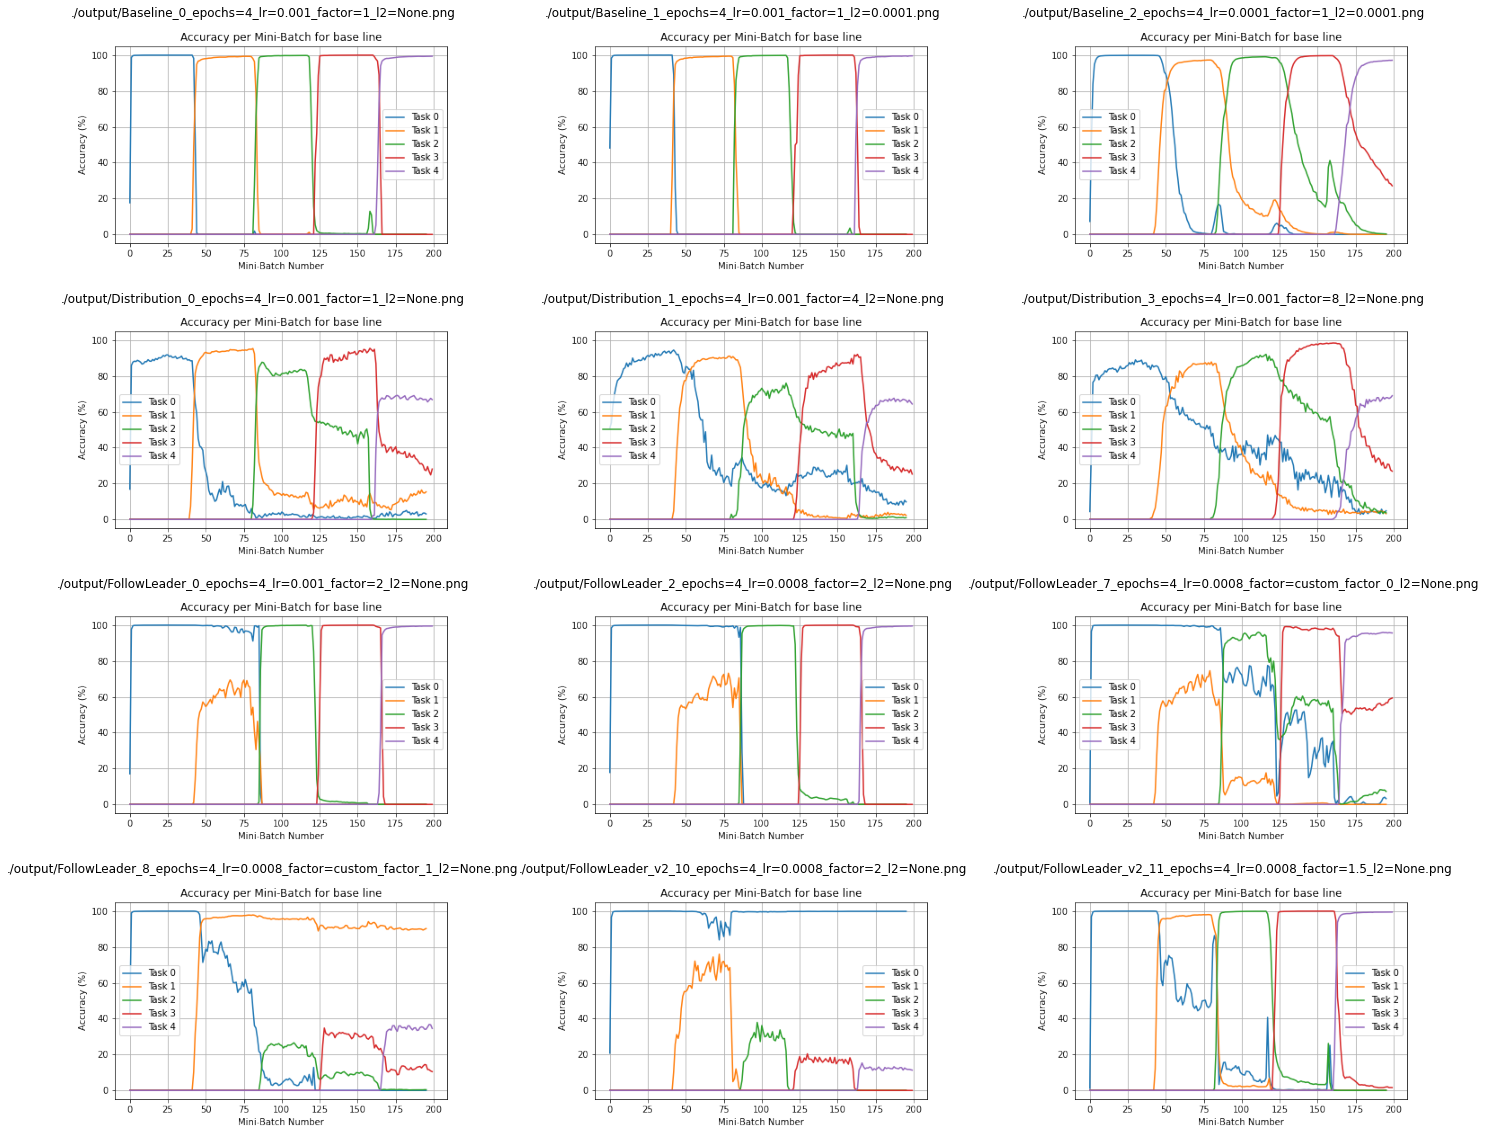

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
import math

ncols = 3
nrows = math.ceil(len(train_settings.keys()) / 3.)

plt.figure(figsize=(21, 4 * nrows))  # Adjust the figure size based on the number of rows
for i, key in enumerate(train_settings.keys()):
    plt.subplot(nrows, ncols, i + 1)

    settings = train_settings[key]
    epochs, lr, l2, loss_type, factor = settings['epochs'], settings['lr'], settings['l2'], settings['loss_type'], settings['factor']

    file_name = f"./output/{key}_epochs={epochs}_lr={lr}_factor={factor}_l2={l2}.png"
    try:
        with Image.open(file_name) as img:
            plt.imshow(img)
            plt.title(f'{file_name}')
            plt.axis('off')
    except FileNotFoundError:
        print(f"Error: The file '{file_name}' does not exist.")
plt.tight_layout()
plt.show()  # Move plt.show() outside the loop to display all subplots at once
